In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:0


In [2]:
from bliss import sleep

In [3]:
import sys
sys.path.append('./starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [6]:
with initialize(config_path="../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [7]:
model_filename = './fits/starnet'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [8]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [9]:
# pl.seed_everything(345435)

# from bliss.datasets import simulated 
# cfg.dataset.kwargs.update({'batch_size': 1})
# dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

# batch =  dataset.get_batch()
# print(sleep_net.get_loss(batch)[0])

# print((batch['images']**2).mean())

# Load m2 data

In [10]:
run = 2583
camcol = 2
field = 136

sdss_frame, hubble_catalog, sdss_background, sdss_data, wcs = \
    m2_data.load_m2_data()

loading sdss image from ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ./hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [11]:
# filter by bright stars 
fmin = 1000.
hubble_catalog = plotting.filter_catalog(hubble_catalog,
                                         hubble_catalog['fluxes'][:, 0] > fmin)

In [12]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

### We focus on this chunk

In [13]:
x0 = 630
x1 = 310
chunk_slen = 100

border_padding = sleep_net.image_encoder.border_padding

In [14]:
sdss_test_image = plotting.crop_image(sdss_frame, 
                                      x0 - border_padding, 
                                      x1 - border_padding,
                                      chunk_slen + 2 * border_padding,
                                      chunk_slen + 2 * border_padding)

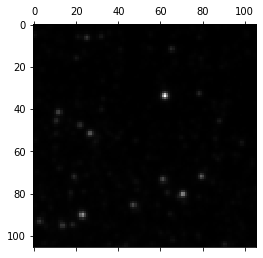

In [15]:
plt.matshow(sdss_test_image[0], 
            cmap = plt.cm.gray)

# Get starnet map estimates

In [16]:
map_estimate = sleep_net.image_encoder.map_estimate(sdss_test_image.unsqueeze(0).to(device), 
                                                    sleep_net.image_decoder.slen)

# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * sleep_net.image_decoder.slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

In [17]:
print(map_estimate['n_sources'])

tensor(1211.)


# Load PCAT results

In [18]:
chain_results = np.load('./fits/my_chain_nsamp3000.npz')

In [19]:
# we take the last 300 samples of the chain
pcat_n_samples = 300

In [20]:
gain = sdss_data[0]['gain'][0]

In [21]:
# n_samples x max_stars x n_bands
pcat_sampled_fluxes = chain_results['f'][:, -pcat_n_samples:, :].transpose([1, 2, 0]) * gain

# get boolean for stars that are on
pcat_is_on_sampled = pcat_sampled_fluxes[:, :, 0] > 0
assert (pcat_is_on_sampled.sum(1) == chain_results['n'][-pcat_n_samples:]).all()

# locations: n_samples x max_stars x 2
pcat_sampled_locs = np.dstack((chain_results['y'][-pcat_n_samples:, :], 
                                    chain_results['x'][-pcat_n_samples:, :])) + \
    np.array([[[630.5, 310.5]]])

# covert everything to torch tensors 
pcat_sampled_locs = torch.Tensor(pcat_sampled_locs) 
pcat_sampled_fluxes = torch.Tensor(pcat_sampled_fluxes)

pcat_samples = dict({'locs': pcat_sampled_locs, 
                     'fluxes': pcat_sampled_fluxes})

# Load DAOPHOT results

In [22]:
import daophot_utils

In [23]:
_daophot_locs, _daophot_fluxes = daophot_utils.load_daophot_results('./daophot_data/m2_2583.phot', 
                                                                    nelec_per_nmgy, 
                                                                    wcs, 
                                                                    slen = 100,
                                                                    x0 = 630,
                                                                    x1 = 310)

In [24]:
daophot_locs, daophot_fluxes = \
    daophot_utils.align_daophot_locs(_daophot_locs,
                                     _daophot_fluxes,
                                     hubble_catalog['locs'],
                                     hubble_catalog['fluxes'][:, 0], 
                                     align_on_logflux = 4.5)

daophot_catalog = {'locs': daophot_locs, 
                   'fluxes': daophot_fluxes}

In [25]:
daophot_locs.shape

torch.Size([357, 2])

# Example subimages

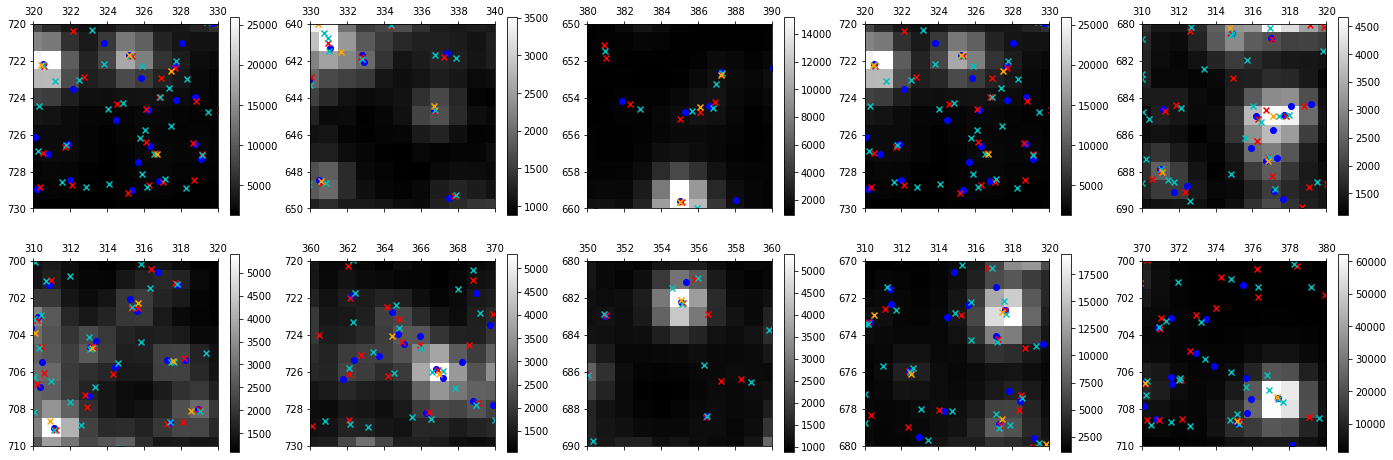

In [26]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
x0_vec = np.arange(x0, x0 + chunk_slen, subimage_slen)
x1_vec = np.arange(x1, x1 + chunk_slen, subimage_slen)

for i in range(10): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        hubble_catalog['locs'], 
        ax,
        marker='o',
        color='b',
    )
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
    plotting.plot_locations(
        pcat_samples['locs'][0], 
        ax,
        marker='x',
        color='c',
    )
    
    plotting.plot_locations(
        daophot_locs, 
        ax,
        marker='x',
        color='orange',
    )
    
    im = plotting.plot_image(ax, 
                             sdss_frame[0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

# Performance metrics

In [27]:
# the PCAT catalog has a 0.5 pixel border around the edges 

# to reproduce old PCAT results, set 
# pad = 5.5
# _chunk_slen = chunk_slen - 10

pad = 0.5
_chunk_slen = chunk_slen - 2 * pad

In [28]:
# get hubble ground truth on this chunk
hubble_test_catalog = plotting.filter_catalog_by_locs(hubble_catalog, 
                                                      x0 + pad, 
                                                      x1 + pad,
                                                      _chunk_slen,
                                                      _chunk_slen)

hubble_test_mags = utils.convert_nmgy_to_mag(hubble_test_catalog['fluxes'][:, 0:1] / nelec_per_nmgy)

In [29]:
def get_summary_statistics(est_catalog): 
        
    est_catalog = plotting.filter_catalog_by_locs(deepcopy(est_catalog),
                                                  x0 + pad, 
                                                  x1 + pad,
                                                  _chunk_slen,
                                                  _chunk_slen)
    est_locs = est_catalog['locs']
    est_fluxes = est_catalog['fluxes'][:, 0:1]
    
    est_mags = utils.convert_nmgy_to_mag(est_fluxes / nelec_per_nmgy)

    # get tpr and ppv as function of magnitude
    tpr_vec = starnet_metrics.get_tpr_vec(hubble_test_catalog['locs'],
                                          hubble_test_mags,
                                          est_locs,
                                          est_mags, 
                                          mag_bins = mag_bins)[0]
    
    ppv_vec = starnet_metrics.get_ppv_vec(hubble_test_catalog['locs'],
                                          hubble_test_mags,
                                          est_locs,
                                          est_mags, 
                                          mag_bins = mag_bins)[0]
    
    # get overal tpr and ppv    
    tpr, ppv = starnet_metrics.get_tpr_ppv(hubble_test_catalog['locs'],
                                           hubble_test_mags,
                                           est_locs,
                                           est_mags, 
                                           slack = 0.5)
    # f1 score 
    f1 = 2 * (tpr * ppv) / (tpr + ppv)
    return tpr, ppv, f1, tpr_vec, ppv_vec


In [30]:
mag_bins = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

### Get results for StarNet

In [31]:
tpr, ppv, f1, starnet_tpr_vec, starnet_ppv_vec = \
    get_summary_statistics(map_estimate)

print('StarNet tpr', tpr)
print('StarNet ppv', ppv)
print('StarNet f1', f1)

StarNet tpr tensor(0.5548)
StarNet ppv tensor(0.5242)
StarNet f1 tensor(0.5391)


### Get results for PCAT

In [32]:
tpr = 0.
ppv = 0.
f1 = 0.

pcat_ppv_vec = torch.zeros(len(mag_bins) - 1)
pcat_tpr_vec = torch.zeros(len(mag_bins) - 1)

for i in range(pcat_n_samples):
    is_on = pcat_is_on_sampled[i]
    
    pcat_catalog_i = {'locs': pcat_sampled_locs[i, is_on, :], 
                      'fluxes': pcat_sampled_fluxes[i, is_on, :]}
    
    tpr_i, ppv_i, f1_i, pcat_tpr_vec, pcat_ppv_vec = \
        get_summary_statistics(pcat_catalog_i)
    
    pcat_tpr_vec += pcat_tpr_vec / pcat_n_samples
    pcat_ppv_vec += pcat_ppv_vec / pcat_n_samples
    
    tpr += tpr_i / pcat_n_samples
    ppv += ppv_i / pcat_n_samples
    f1 += f1_i / pcat_n_samples
    
print('PCAT tpr', tpr)
print('PCAT ppv', ppv)
print('PCAT f1', f1)

PCAT tpr tensor(0.5495)
PCAT ppv tensor(0.3706)
PCAT f1 tensor(0.4426)


### Get results for DAOPHOT

In [33]:
tpr, ppv, f1, daophot_tpr_vec, daophot_ppv_vec = \
    get_summary_statistics(daophot_catalog)

print('DAOPHOT tpr', tpr)
print('DAOPHOT ppv', ppv)
print('DAOPHOT f1', f1)

DAOPHOT tpr tensor(0.2047)
DAOPHOT ppv tensor(0.6496)
DAOPHOT f1 tensor(0.3113)


# Get performance metrics statistics as a function of magnitude

In [34]:
axis_label_size = 20
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2
titlesize = 18

In [35]:
def plot_summary_vec(summary_vec, ax, marker, color, label): 
    ax.plot(x_tmp[:-1],
            summary_vec,
            marker, 
            markersize = markersize, 
            linewidth = linewidth, 
            color = color, 
            label = label)


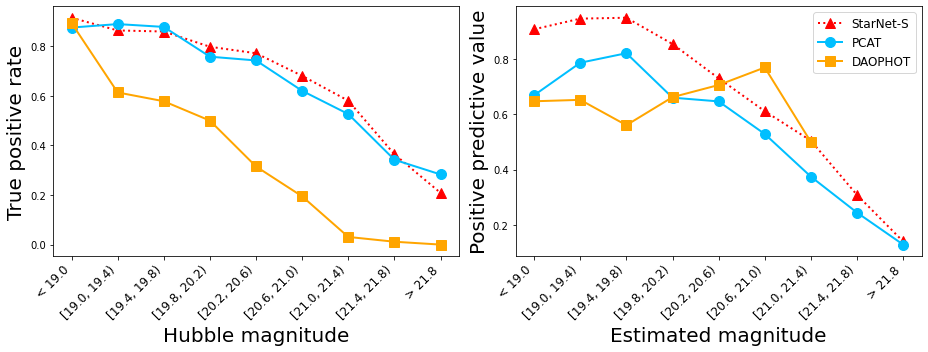

In [36]:
fig, axarr = plt.subplots(1, 2, figsize=(13, 5))

x_tmp = np.arange(len(mag_bins))

############### 
# true positive rates
###############
plot_summary_vec(starnet_tpr_vec, 
                 axarr[0], 
                 marker = ':^', 
                 color = 'r', 
                 label = 'StarNet-S')

plot_summary_vec(pcat_tpr_vec, 
                 axarr[0], 
                 marker = '-o', 
                 color = 'deepskyblue', 
                 label = 'PCAT')

plot_summary_vec(daophot_tpr_vec, 
                 axarr[0], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT')

################
# positive predictive values
###############
plot_summary_vec(starnet_ppv_vec, 
                 axarr[1], 
                 marker = ':^', 
                 color = 'r', 
                 label = 'StarNet-S')

plot_summary_vec(pcat_ppv_vec, 
                 axarr[1], 
                 marker = '-o', 
                 color = 'deepskyblue', 
                 label = 'PCAT')

# no detection at lower magnitudes. 
# don't plot them
daophot_ppv_vec[daophot_ppv_vec == 0] = np.inf
plot_summary_vec(daophot_ppv_vec, 
                 axarr[1], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT')

###############
# Legend
###############
axarr[1].legend(prop={'size': legendsize})

###############
# axis labels
###############
axarr[0].set_xlabel('Hubble magnitude', fontsize = axis_label_size)
axarr[1].set_xlabel('Estimated magnitude', fontsize = axis_label_size)
axarr[0].set_ylabel('True positive rate', fontsize = axis_label_size)
axarr[1].set_ylabel('Positive predictive value', fontsize = axis_label_size)


labels_raw = np.round(mag_bins, 1)
labels = ['[' + str(labels_raw[i]) + ', ' + str(labels_raw[i+1]) + ')' for i in range(len(labels_raw) - 1)]

labels[0] = '< ' + str(labels_raw[1])
labels[-1] = '> ' + str(labels_raw[-2])

for i in range(2): 
    axarr[i].set_xticks(x_tmp[:-1])
    axarr[i].set_xticklabels(labels, rotation=45, ha = 'right', 
                             fontsize = axis_label_size * 0.6)

fig.tight_layout()


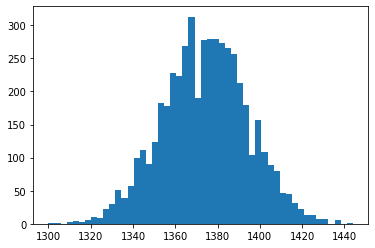

In [37]:
samples = sleep_net.image_encoder.sample_encoder(sdss_test_image.unsqueeze(0).to(device), 5000)
plt.hist(samples['n_sources'].sum(1).cpu().numpy(), bins = 50);

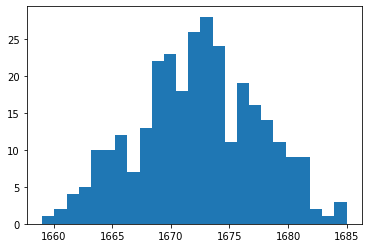

In [54]:
pcat_n_stars = (pcat_samples['fluxes'][:, :, 0] > 0).sum(1)
plt.hist(pcat_n_stars.cpu().numpy(), bins = 25);

In [49]:
hubble_test_catalog['locs'].shape

torch.Size([1114, 2])

In [ ]:
# np.savez('../../data/true_hubble_m2', 
#          sdss_image = sdss_image.cpu(), 
#          true_locs = hubble_locs.cpu(), 
#          true_fluxes = hubble_fluxes.cpu(), 
#          nelec_per_nmgy = nelec_per_nmgy)